In [41]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
df = pd.read_csv("cybersecurity_attacks.csv")

df.head(2)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall


In [ ]:
# Selecting features from the all the columns which are importent
selected_features = [
    'Source Port', 'Destination Port', 'Protocol', 'Packet Length', 'Packet Type',
    'Traffic Type', 'Anomaly Scores', 'Attack Signature', 'Action Taken',
    'Severity Level', 'Network Segment', 'Log Source'
]

# here we can take any or all the conditions to detect if it is counted as suspicious
condition = (
    (df['Anomaly Scores'] > 50)
    # (df['Anomaly Scores'] > 50) |
    # (df['Alerts/Warnings'].notna()) |
    # (df['Malware Indicators'].notna())
)

# with the help of the upper one condition or conditions make the column for marking
df['is_suspicious'] = condition.astype(int)

df_model = df[selected_features + ['is_suspicious']]

df_model.head()

,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Anomaly Scores,Attack Signature,Action Taken,Severity Level,Network Segment,Log Source,is_suspicious
0,31225,17616,ICMP,503,Data,HTTP,28.67,Known Pattern B,Logged,Low,Segment A,Server,0
1,17245,48166,ICMP,1174,Data,HTTP,51.50,Known Pattern A,Blocked,Low,Segment B,Firewall,1
2,16811,53600,UDP,306,Control,HTTP,87.42,Known Pattern B,Ignored,Low,Segment C,Firewall,1
3,20018,32534,UDP,385,Data,HTTP,15.79,Known Pattern B,Blocked,Medium,Segment B,Firewall,0
4,6131,26646,TCP,1462,Data,DNS,0.52,Known Pattern B,Blocked,Low,Segment C,Firewall,0


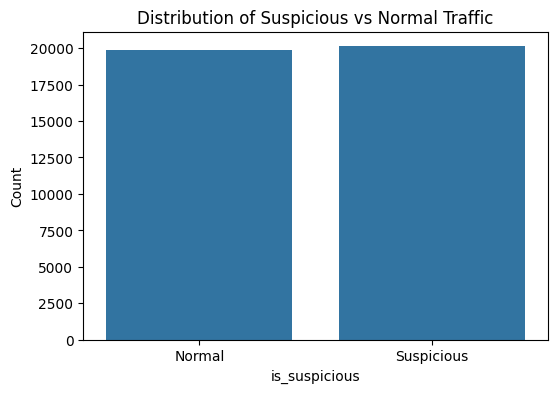

In [55]:
# Check how many suspicious vs normal
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_suspicious')
plt.title("Distribution of Suspicious vs Normal Traffic")
plt.xticks([0, 1], ['Normal', 'Suspicious'])
plt.ylabel("Count")
plt.show()


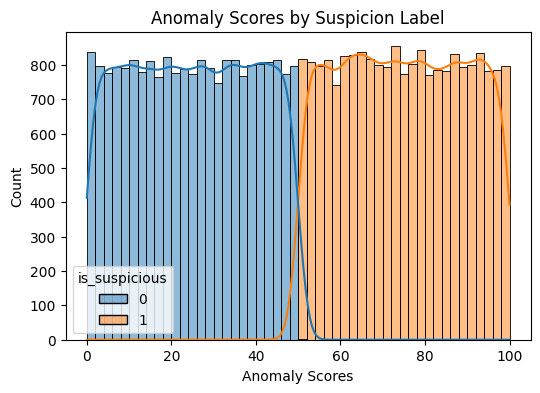

In [56]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='Anomaly Scores', hue='is_suspicious', bins=50, kde=True)
plt.title("Anomaly Scores by Suspicion Label")
plt.show()

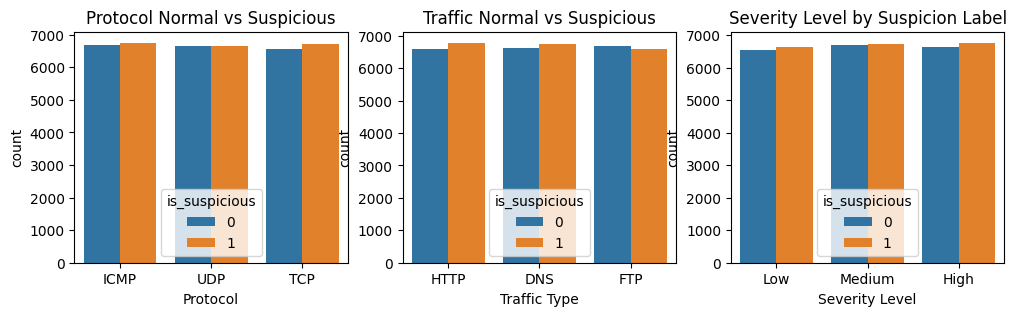

In [57]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='Protocol', hue='is_suspicious')
plt.title("Protocol Normal vs Suspicious")

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='Traffic Type', hue='is_suspicious')
plt.title("Traffic Normal vs Suspicious")

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='Severity Level', hue='is_suspicious')
plt.title("Severity Level by Suspicion Label")
plt.show()

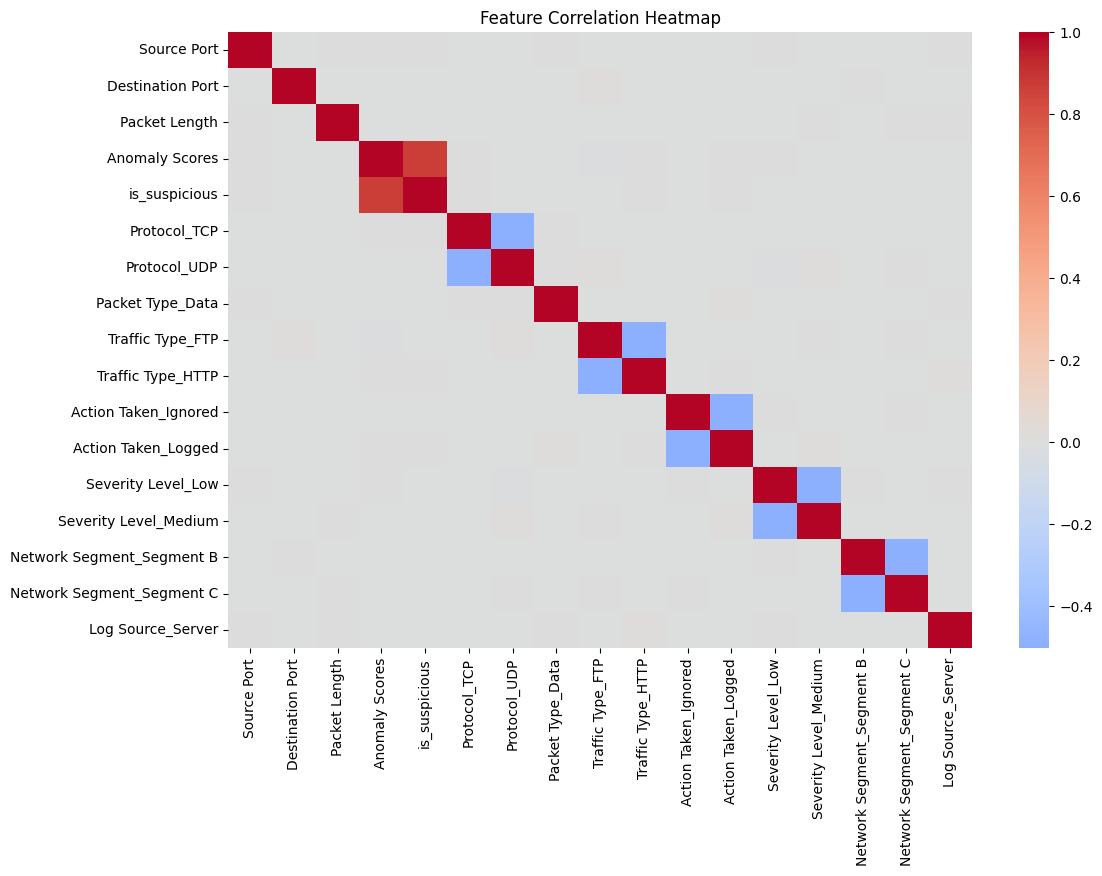

In [ ]:
# Encode categorical features temporarily for correlation
df_encoded = df.copy()
categorical_cols = ['Protocol', 'Packet Type', 'Traffic Type', 'Action Taken', 'Severity Level', 'Network Segment', 'Log Source']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


Top correlated features with is_suspicious:
Anomaly Scores                      0.865759
Action Taken_Logged                 0.006659
Traffic Type_HTTP                   0.006104
Protocol_TCP                        0.003915
Source Port                         0.003463
Attack Signature_Known Pattern B    0.001925
Log Source_Server                   0.001738
Network Segment_Segment C           0.000151
Severity Level_Low                 -0.000143
Severity Level_Medium              -0.002770
Name: is_suspicious, dtype: float64


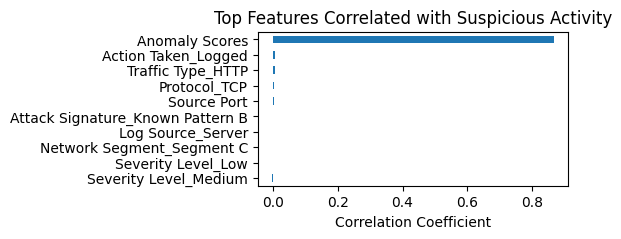

In [ ]:
selected_features = [
    'Source Port', 'Destination Port', 'Protocol', 'Packet Length', 'Packet Type',
    'Traffic Type', 'Anomaly Scores', 'Attack Signature', 'Action Taken',
    'Severity Level', 'Network Segment', 'Log Source', 'is_suspicious'
]

df_selected = df[selected_features]

df_encoded = pd.get_dummies(df_selected, drop_first=True)



correlation_matrix = df_encoded.corr()
cor_target = correlation_matrix['is_suspicious'].sort_values(ascending=False)

# Displaying the top features
print("Top correlated features with is_suspicious:")
print(cor_target[1:11])  # Skip self-correlation at index 0

plt.figure(figsize=(4, 2))
cor_target[1:11].plot(kind='barh')
plt.title("Top Features Correlated with Suspicious Activity")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()
plt.show()


it is showing like that as t is calculated based on th e anomaly score first here can be put others condition also in the previous to get better or a better dataset 

In [60]:
X = df_encoded.drop('is_suspicious', axis=1)
y = df_encoded['is_suspicious']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# With nural network

model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


C:\Users\subha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9054 - loss: 0.2378 - val_accuracy: 0.9891 - val_loss: 0.0287
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9909 - loss: 0.0250 - val_accuracy: 0.9912 - val_loss: 0.0201
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9952 - loss: 0.0145 - val_accuracy: 0.9909 - val_loss: 0.0172
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9967 - loss: 0.0102 - val_accuracy: 0.9950 - val_loss: 0.0101
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9972 - loss: 0.0073 - val_accuracy: 0.9931 - val_loss: 0.0119
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9979 - loss: 0.0058 - val_accuracy: 0.9956 - val_loss: 0.0091
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9982 - loss: 0.0046 - val_accuracy: 0.9950 - val_loss: 0.0090
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9986 - loss: 0.0038 - val_accuracy: 0.9950 - val_

In [ ]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
[[3957   17]
 [  15 4011]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3974
           1       1.00      1.00      1.00      4026

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [ ]:
model.save("web_threat_detector.h5")

import joblib
joblib.dump(scaler, "scaler.pkl")

joblib.dump(X.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']